<a href="https://colab.research.google.com/github/shreyas269/Pytorch-defensive-distillation/blob/master/Distilled_Conv_CIFAR10_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import path
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wF7ighX4qdLxqiPc9iyJ2CPGuDVMakTOTpCbiOQgUwv3-i0cQ8Zm_g
Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
std = np.array((0.5, 0.5, 0.5))
mean = np.array((0.5, 0.5, 0.5))
epochs = 50
training_batch_size = 128
validation_batch_size = 128
lrn_rate = 0.01
path_model = F"/content/gdrive/My Drive/Distilled Models/model"
path_model_init = F"/content/gdrive/My Drive/Distilled Models/model_init"
path_teacher = F"/content/gdrive/My Drive/Distilled Models/teacher"
path_student = F"/content/gdrive/My Drive/Distilled Models/student"
baseline_temperature = 1
distilled_temperature = 100

In [ ]:
# Declaring and assigning Hyperparameters in a namedtuple
HParams = namedtuple('HPS', 'std, mean, epochs, training_batch_size, validation_batch_size, lrn_rate, path_model, path_teacher, path_student, path_model_init, baseline_temperature, distilled_temperature')
hps = HParams(std=std, mean=mean, epochs=epochs, training_batch_size=training_batch_size, validation_batch_size=validation_batch_size, lrn_rate=lrn_rate, path_model=path_model, path_teacher=path_teacher, path_student=path_student, path_model_init=path_model_init, baseline_temperature=baseline_temperature, distilled_temperature=distilled_temperature)

In [ ]:
# In PyTorch, images are represented as [channels, height, width]
# For a 256x256 coloured image, [channels, height, width] = [3, 256, 256]
# For grayscale, channels=1

# "transforms" are common image transformations
# tansforms.Compose chains together transformations
# ToTensor() converts numpy array (PIL image) to FloatTensor in range [0.0, 1.0]. Transforms numpy [H, W, C] to Tensor [C, H, W]

# If using data-augmentation techniques
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Three channels to normalize since CIFAR is RGB
                               ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# This maps image FloatTensor values from [0.0, 1.0] to [-1.0, 1.0]

In [ ]:
training_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)

# Changing labels to multi-hot encoding
target_classes = torch.zeros(len(training_dataset.targets), 10)
target_classes[range(target_classes.shape[0]), training_dataset.targets]=1
training_dataset.targets = target_classes

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
validation_dataset = datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)

# Changing labels to multi-hot encoding
target_classes = torch.zeros(len(validation_dataset.targets), 10)
target_classes[range(target_classes.shape[0]), validation_dataset.targets]=1
validation_dataset.targets = target_classes

Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# NN Class model
class LeNet(nn.Module):
    def __init__(self):
      super().__init__() # To inherit all methods from parent class

      self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1) # args = (input_channels, output_channels, kernel_size, stride_length)
      self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
      self.conv4 = nn.Conv2d(128, 128, 3, 1, padding=1)

      # Calculations: 
      # No. of neurons in FC1 is (Number of channels)*(size of each channel after max pooling in conv3)
      # 32x32 -> conv1 -> 32x32 (after padding) -> conv2 -> 32x32 (after padding) -> max_pool1 -> 16x16 -> conv3 -> 16x16 (after padding) -> conv4 -> 16x16 (after padding) -> max_pool2 -> 8x8
      # size of each channel after max pooling in conv3 = 8*8
      # Number of channels = 128
      # No. of neurons in FC1 = 128*(8*8)

      self.fc1 = nn.Linear(8*8*128, 256)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(256, 256)
      self.dropout2 = nn.Dropout(0.5)
      self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
      # Defining architecture of NN
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 8*8*128) # Flattens to 1x8*8*128 row vector
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = F.relu(self.fc2(x))
      x = self.dropout2(x)
      x = self.fc3(x)

      return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
teacher = LeNet().to(device)
student = LeNet().to(device)
model_init = LeNet().to(device)

In [ ]:
# Define Loss
# criterion = nn.CrossEntropyLoss()

def SoftCrossEntropyLoss(predicted, target):
  return -(target * F.log_softmax(predicted, dim=1)).sum(dim=1).mean()

criterion = SoftCrossEntropyLoss

In [ ]:
def train_batch(model, train_loader, temperature, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output/temperature, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % (hps.training_batch_size) == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))


def check_model_performance(model, loader, temperature):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += criterion(output/temperature, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()

    loss /= len(loader.dataset)

    return loss, correct

In [ ]:
def train(model, epochs, temperature, path):
  training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=hps.training_batch_size, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=hps.validation_batch_size, shuffle=False)

  optimizer = torch.optim.SGD(model.parameters(), lr=hps.lrn_rate, momentum=0.9, weight_decay=1e-6, nesterov=True)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)

  for e in range(epochs):
    train_batch(model, training_loader, temperature, optimizer, e)
    loss_train, correct_train = check_model_performance(model, training_loader, temperature)

    loss_test, correct_test = check_model_performance(model, validation_loader, temperature)
    print('Epoch {} | Train set: Avg Batch loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) | Test set: Avg Batch loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        e+1, hps.training_batch_size * loss_train.item(), correct_train, len(training_loader.dataset),
        100. * correct_train / len(training_loader.dataset), hps.validation_batch_size * loss_test.item(), correct_test, len(validation_loader.dataset),
        100. * correct_test / len(validation_loader.dataset)))
    
    scheduler.step()

  torch.save(model.state_dict(), path)

In [ ]:
if not path.exists(hps.path_model): 
  train(model, hps.epochs, hps.baseline_temperature, hps.path_model)
else:
  model.load_state_dict(torch.load(hps.path_model))

Epoch 1 | Train set: Avg Batch loss: 1.7410, Accuracy: 18280/50000 (37%) | Test set: Avg Batch loss: 1.7540, Accuracy: 3726/10000 (37%)
Epoch 2 | Train set: Avg Batch loss: 1.3711, Accuracy: 24630/50000 (49%) | Test set: Avg Batch loss: 1.3902, Accuracy: 4874/10000 (49%)
Epoch 3 | Train set: Avg Batch loss: 1.1682, Accuracy: 28640/50000 (57%) | Test set: Avg Batch loss: 1.2105, Accuracy: 5618/10000 (56%)
Epoch 4 | Train set: Avg Batch loss: 0.9480, Accuracy: 33105/50000 (66%) | Test set: Avg Batch loss: 1.0092, Accuracy: 6450/10000 (64%)
Epoch 5 | Train set: Avg Batch loss: 0.8221, Accuracy: 35562/50000 (71%) | Test set: Avg Batch loss: 0.9056, Accuracy: 6877/10000 (69%)
Epoch 6 | Train set: Avg Batch loss: 0.7076, Accuracy: 37669/50000 (75%) | Test set: Avg Batch loss: 0.8310, Accuracy: 7155/10000 (72%)
Epoch 7 | Train set: Avg Batch loss: 0.6051, Accuracy: 39556/50000 (79%) | Test set: Avg Batch loss: 0.7609, Accuracy: 7435/10000 (74%)
Epoch 8 | Train set: Avg Batch loss: 0.5230, Acc

In [ ]:
# Initialize a temporary model to get a good starting point for teacher and student models
if not path.exists(hps.path_model_init):
  train(model_init, 1, hps.baseline_temperature, hps.path_model_init)
else:
  model_init.load_state_dict(torch.load(hps.path_model_init))

Epoch 1 | Train set: Avg Batch loss: 1.8414, Accuracy: 16699/50000 (33%) | Test set: Avg Batch loss: 1.8510, Accuracy: 3400/10000 (34%)


In [ ]:
if not path.exists(hps.path_teacher):
  teacher.load_state_dict(torch.load(hps.path_model_init))
  train(teacher, hps.epochs, hps.distilled_temperature, hps.path_teacher)
else:
  teacher.load_state_dict(torch.load(hps.path_teacher))

Epoch 1 | Train set: Avg Batch loss: 1.8552, Accuracy: 15633/50000 (31%) | Test set: Avg Batch loss: 1.8602, Accuracy: 3170/10000 (32%)
Epoch 2 | Train set: Avg Batch loss: 1.6375, Accuracy: 20016/50000 (40%) | Test set: Avg Batch loss: 1.6434, Accuracy: 4035/10000 (40%)
Epoch 3 | Train set: Avg Batch loss: 1.5472, Accuracy: 21461/50000 (43%) | Test set: Avg Batch loss: 1.5538, Accuracy: 4321/10000 (43%)
Epoch 4 | Train set: Avg Batch loss: 1.4879, Accuracy: 22612/50000 (45%) | Test set: Avg Batch loss: 1.4965, Accuracy: 4562/10000 (46%)
Epoch 5 | Train set: Avg Batch loss: 1.4441, Accuracy: 23515/50000 (47%) | Test set: Avg Batch loss: 1.4552, Accuracy: 4676/10000 (47%)
Epoch 6 | Train set: Avg Batch loss: 1.4049, Accuracy: 24387/50000 (49%) | Test set: Avg Batch loss: 1.4227, Accuracy: 4790/10000 (48%)
Epoch 7 | Train set: Avg Batch loss: 1.3453, Accuracy: 25474/50000 (51%) | Test set: Avg Batch loss: 1.3696, Accuracy: 4991/10000 (50%)
Epoch 8 | Train set: Avg Batch loss: 1.3197, Acc

In [ ]:
# Setting outputs from teacher model as new label distribution
batch_size = 100 # A factor of num training examples = 50000
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=False)

i=0
for inputs, labels in training_loader:
  
  inputs = inputs.to(device)
  labels = labels.to(device)
  
  outputs = teacher(inputs)
  outputs = F.softmax(outputs, dim=1)
  outputs = outputs.detach().cpu()
  training_dataset.targets[batch_size*i : batch_size*(i+1), :] = outputs

  i = i+1

In [ ]:
if not path.exists(hps.path_student):
  student.load_state_dict(torch.load(hps.path_model_init))
  train(student, hps.epochs, hps.distilled_temperature, hps.path_student)
else:
  student.load_state_dict(torch.load(hps.path_student))

Epoch 1 | Train set: Avg Batch loss: 1.8480, Accuracy: 16062/50000 (32%) | Test set: Avg Batch loss: 1.8568, Accuracy: 3247/10000 (32%)
Epoch 2 | Train set: Avg Batch loss: 1.6679, Accuracy: 19607/50000 (39%) | Test set: Avg Batch loss: 1.6779, Accuracy: 3912/10000 (39%)
Epoch 3 | Train set: Avg Batch loss: 1.5433, Accuracy: 21444/50000 (43%) | Test set: Avg Batch loss: 1.5548, Accuracy: 4305/10000 (43%)
Epoch 4 | Train set: Avg Batch loss: 1.4914, Accuracy: 22427/50000 (45%) | Test set: Avg Batch loss: 1.5091, Accuracy: 4492/10000 (45%)
Epoch 5 | Train set: Avg Batch loss: 1.4726, Accuracy: 23090/50000 (46%) | Test set: Avg Batch loss: 1.4930, Accuracy: 4578/10000 (46%)
Epoch 6 | Train set: Avg Batch loss: 1.3889, Accuracy: 24538/50000 (49%) | Test set: Avg Batch loss: 1.4147, Accuracy: 4831/10000 (48%)
Epoch 7 | Train set: Avg Batch loss: 1.3468, Accuracy: 25459/50000 (51%) | Test set: Avg Batch loss: 1.3767, Accuracy: 4956/10000 (50%)
Epoch 8 | Train set: Avg Batch loss: 1.3028, Acc

In [ ]:
original_training_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
# Changing labels to multi-hot encoding
target_classes = torch.zeros(len(original_training_dataset.targets), 10)
target_classes[range(target_classes.shape[0]), original_training_dataset.targets]=1
original_training_dataset.targets = target_classes

Files already downloaded and verified


In [ ]:
def plot_gradients(gradients_list_correct_samples, gradients_list_wrong_samples):
  x_in = list(range(1, len(gradients_list_correct_samples)+1))
  plt.scatter(x_in, gradients_list_correct_samples, label='correctly classified', color='b', s=0.1)
  plt.ylabel('gradients')
  plt.xlabel('images')
  plt.title('Adversarial input gradients of validation samples w.r.t its correct labels')
  plt.legend()
  plt.show()

  x_in = list(range(1, len(gradients_list_wrong_samples)+1))
  plt.scatter(x_in, gradients_list_wrong_samples, label='wrongly classified', color='r', s=0.1)
  plt.ylabel('gradients')
  plt.xlabel('images')
  plt.title('Adversarial input gradients of validation samples w.r.t its correct labels')
  plt.legend()
  plt.show()

In [ ]:
def calculate_gradients(model, loader, temperature):
  t0 = time.time()
  num_classes = 10
  N = len(loader)

  gradients_list_correct_samples = []
  gradients_list_wrong_samples = []

  for j, data in enumerate(loader):
    images, true_labels = data
    true_labels = true_labels.to(device)

    inputs = Variable(images.to(device), requires_grad=True)
    outputs = model(inputs)
    outputs=outputs/temperature

    nnOutputs = outputs.data.cpu()
    nnOutputs = nnOutputs.numpy()
    nnOutputs = nnOutputs[0]

    nnSoftmax = nnOutputs - np.max(nnOutputs)
    nnSoftmax = np.exp(nnSoftmax) / np.sum(np.exp(nnSoftmax))

    arg_max = np.argmax(nnOutputs)
    max_softmax = np.max(nnSoftmax)

    labels = torch.tensor(nnSoftmax, requires_grad=False)
    labels = labels.view(1, labels.shape[0]).to(device)
    
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    grad_vec = inputs.grad
    grad_norm = grad_vec.norm().item()

    classification = (true_labels.argmax() == labels.argmax()).item()

    if classification == True:
      gradients_list_correct_samples.append(grad_norm)
    else:
      gradients_list_wrong_samples.append(grad_norm)


    if j % 1000 == 999:
        print("{:4}/{:4} images processed, {:.1f} seconds used.".format(j + 1, N, time.time() - t0))
        t0 = time.time()

    if j == N - 1: break

  print("\nTotal number of exactly zero gradients = ", gradients_list_correct_samples.count(0.0), "/", len(gradients_list_correct_samples), "\n")

  plot_gradients(gradients_list_correct_samples, gradients_list_wrong_samples)

## Temperature 1 in the student model causes extremely high logit values implying softmax scores like 1-9$\epsilon$ for highest class and $\epsilon$ for all other classes
* The floating point number gets approximated to 0.0 in this case. 
* Therefore gradient values for correct classes are very low, ~0.0
* For wrongly classified samples, this does not happen and we see very high gradient values for them implying that distillation actually fails!


1000/10000 images processed, 3.5 seconds used.
2000/10000 images processed, 3.4 seconds used.
3000/10000 images processed, 3.4 seconds used.
4000/10000 images processed, 3.4 seconds used.
5000/10000 images processed, 3.4 seconds used.
6000/10000 images processed, 3.4 seconds used.
7000/10000 images processed, 3.4 seconds used.
8000/10000 images processed, 3.4 seconds used.
9000/10000 images processed, 3.4 seconds used.
10000/10000 images processed, 3.4 seconds used.

Total number of exactly zero gradients =  7582 / 7685 



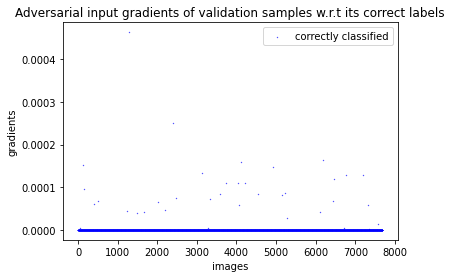

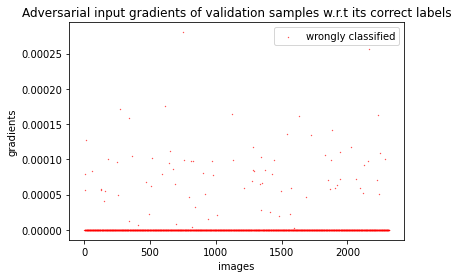

In [ ]:
temperature = 1
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1, shuffle=False)

calculate_gradients(student, validation_loader, temperature)

## Temperature 100 in the student model scales down the logit values and hence softmax scores are within the 32 bit floating point

* The gradient values for correctly classified samples are represented appropriately in this case
* For wrongly classified samples, the gradient norm is very large which is a consistent observation as loss is large for wrongly classified samples. 

1000/10000 images processed, 3.5 seconds used.
2000/10000 images processed, 3.5 seconds used.
3000/10000 images processed, 3.4 seconds used.
4000/10000 images processed, 3.4 seconds used.
5000/10000 images processed, 3.4 seconds used.
6000/10000 images processed, 3.4 seconds used.
7000/10000 images processed, 3.4 seconds used.
8000/10000 images processed, 3.4 seconds used.
9000/10000 images processed, 3.4 seconds used.
10000/10000 images processed, 3.4 seconds used.

Total number of exactly zero gradients =  291 / 7685 



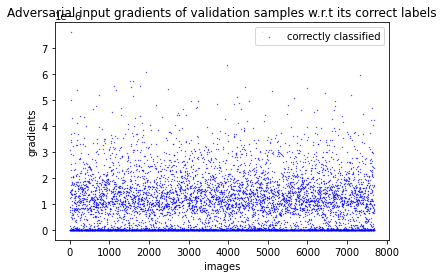

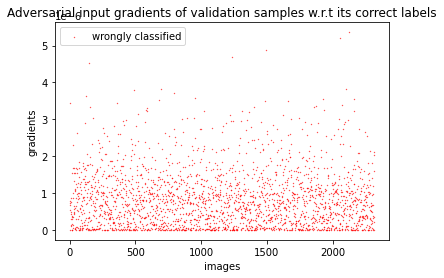

In [ ]:
temperature = 100
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1, shuffle=False)

calculate_gradients(student, validation_loader, temperature)

## This is Baseline model
* There is not much distinction between basline gradients when compared to distilled model gradients
* So, weights of distilled model are scaled up by the temperature factor when learning the distilled model. At inference, however we downscale logits by the same temperature factor (otherwise it doesn't make sense - you can just take an existing model and multiply all its weights by the temperature factor; why train a distilled model?)
* So technically, it seems like defensive distillation does nothing!!

1000/10000 images processed, 3.4 seconds used.
2000/10000 images processed, 3.4 seconds used.
3000/10000 images processed, 3.4 seconds used.
4000/10000 images processed, 3.4 seconds used.
5000/10000 images processed, 3.4 seconds used.
6000/10000 images processed, 3.4 seconds used.
7000/10000 images processed, 3.4 seconds used.
8000/10000 images processed, 3.4 seconds used.
9000/10000 images processed, 3.4 seconds used.
10000/10000 images processed, 3.4 seconds used.

Total number of exactly zero gradients =  2079 / 8145 



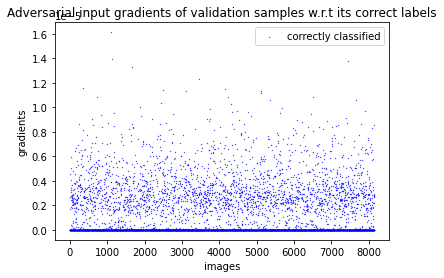

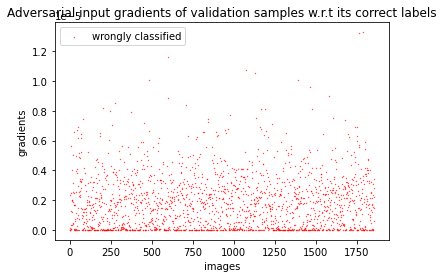

In [ ]:
temperature = 1
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1, shuffle=False)

calculate_gradients(model, validation_loader, temperature)

In [ ]:
!wget https://www.dropbox.com/s/avgm2u562itwpkl/Imagenet.tar.gz
!tar -xvzf Imagenet.tar.gz

Streaming output truncated to the last 5000 lines.
Imagenet/test/3747.png
Imagenet/test/5118.png
Imagenet/test/1965.png
Imagenet/test/6829.png
Imagenet/test/6650.png
Imagenet/test/1783.png
Imagenet/test/5957.png
Imagenet/test/442.png
Imagenet/test/6116.png
Imagenet/test/4162.png
Imagenet/test/2206.png
Imagenet/test/1471.png
Imagenet/test/2392.png
Imagenet/test/4862.png
Imagenet/test/6315.png
Imagenet/test/1412.png
Imagenet/test/9503.png
Imagenet/test/8145.png
Imagenet/test/1524.png
Imagenet/test/262.png
Imagenet/test/8953.png
Imagenet/test/1544.png
Imagenet/test/3998.png
Imagenet/test/5350.png
Imagenet/test/9874.png
Imagenet/test/2776.png
Imagenet/test/1957.png
Imagenet/test/1752.png
Imagenet/test/6276.png
Imagenet/test/8313.png
Imagenet/test/3427.png
Imagenet/test/2253.png
Imagenet/test/9717.png
Imagenet/test/5471.png
Imagenet/test/7236.png
Imagenet/test/9434.png
Imagenet/test/5562.png
Imagenet/test/7866.png
Imagenet/test/1839.png
Imagenet/test/1197.png
Imagenet/test/1934.png
Imagenet

1000/10000 images processed, 3.6 seconds used.
2000/10000 images processed, 3.6 seconds used.
3000/10000 images processed, 3.6 seconds used.
4000/10000 images processed, 3.6 seconds used.
5000/10000 images processed, 3.7 seconds used.
6000/10000 images processed, 3.6 seconds used.
7000/10000 images processed, 3.7 seconds used.
8000/10000 images processed, 3.6 seconds used.
9000/10000 images processed, 3.6 seconds used.
10000/10000 images processed, 3.6 seconds used.

Total number of exactly zero gradients =  0 / 1282 



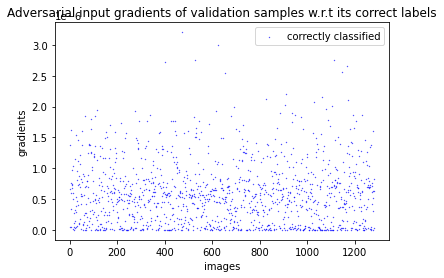

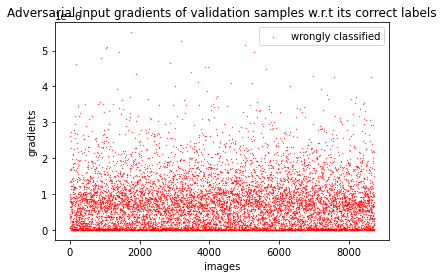

In [ ]:
ood_dataset = torchvision.datasets.ImageFolder("{}".format("Imagenet"), transform=transform)
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=1, shuffle=False)

temperature = 100
calculate_gradients(student, ood_loader, temperature)

1000/10000 images processed, 3.7 seconds used.
2000/10000 images processed, 3.7 seconds used.
3000/10000 images processed, 3.7 seconds used.
4000/10000 images processed, 3.6 seconds used.
5000/10000 images processed, 3.6 seconds used.
6000/10000 images processed, 3.6 seconds used.
7000/10000 images processed, 3.7 seconds used.
8000/10000 images processed, 3.6 seconds used.
9000/10000 images processed, 3.6 seconds used.
10000/10000 images processed, 3.7 seconds used.

Total number of exactly zero gradients =  0 / 1377 



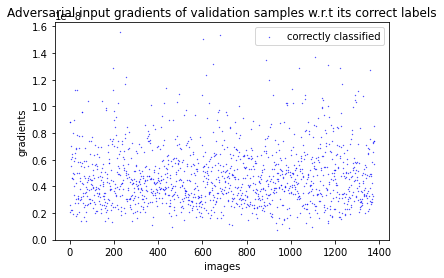

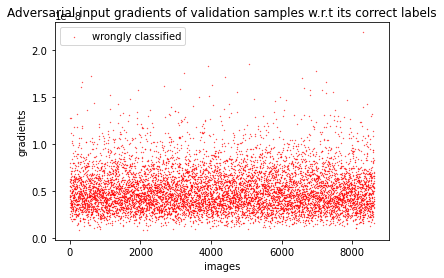

In [ ]:
temperature = 100
calculate_gradients(model, ood_loader, temperature)